In [14]:
import pandas as pd 

df = pd.read_csv("C:/Users/Hesam/Desktop/tesla_stock_history.csv")
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,6/29/2010,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,6/30/2010,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,7/1/2010,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,7/2/2010,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,7/6/2010,1.074000,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...,...,...
3866,11/10/2025,445.230011,445.230011,449.670013,433.359985,439.600006,76515900
3867,11/11/2025,439.619995,439.619995,442.489990,432.359985,439.399994,60533200
3868,11/12/2025,430.600006,430.600006,442.329987,426.559998,442.149994,58513500
3869,11/13/2025,401.989990,401.989990,424.500000,396.339996,423.130005,118948000


✅ Libraries Imported Successfully!
✅ Dataset Loaded.
✅ Data Shapes Fixed: X=(3056, 7), y=(3056,)

🚀 Training Regression Model...
✅ Regression Training Done.

🚀 Training Classification Model...
✅ Classification Training Done.


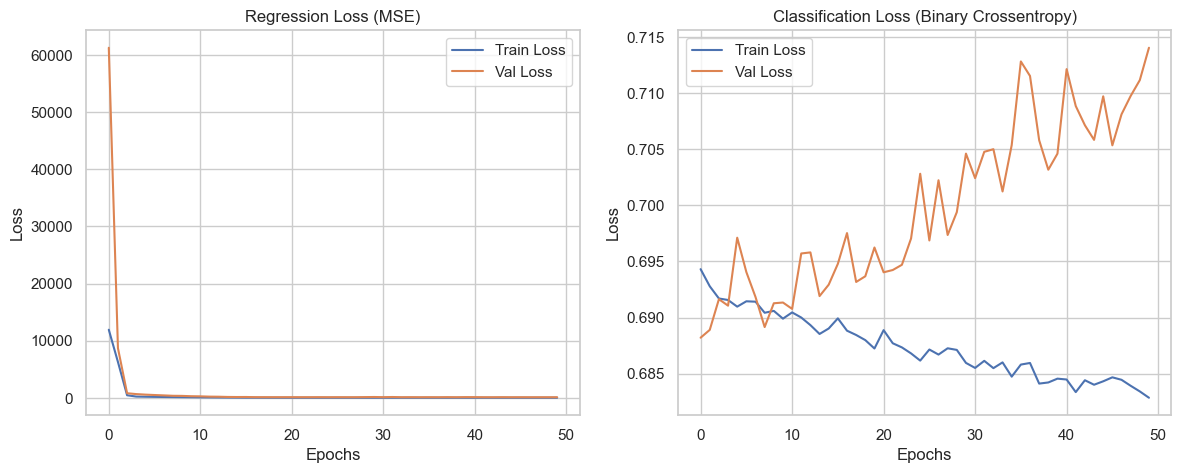

In [17]:
# --- 1. فراخوانی کتابخانه‌ها ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# تنظیمات
sns.set(style="whitegrid")
print("✅ Libraries Imported Successfully!")

# --- 2. بارگذاری و آماده‌سازی داده‌ها ---
try:
    df = pd.read_csv("C:/Users/Hesam/Desktop/tesla_stock_history.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    print("✅ Dataset Loaded.")
except:
    # ساخت دیتای تستی اگر فایل نبود (برای جلوگیری از ارور)
    print("⚠️ فایل پیدا نشد! استفاده از دیتای ساختگی...")
    dates = pd.date_range(start='2020-01-01', periods=1000)
    close = np.cumsum(np.random.randn(1000)) + 100
    df = pd.DataFrame({'Date': dates, 'Close': close, 'Open': close+1, 'High': close+2, 'Low': close-1, 'Volume': 1000})

# مهندسی ویژگی
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['Return'] = df['Close'].pct_change()

# --- ساخت ستون‌های هدف (Target) در خود دیتافریم ---
# نکته مهم: اول هدف را می‌سازیم، بعد NaNها را حذف می‌کنیم تا طول همه برابر شود
df['Target_Reg'] = df['Close'].shift(-1)  # قیمت فردا
df['Target_Class'] = (df['Close'].shift(-1) > df['Close']).astype(int) # صعود/نزول

# حذف تمام ردیف‌های خالی (هم ناشی از میانگین‌گیری و هم شیفت آخر)
df.dropna(inplace=True)

# --- تعریف ورودی و خروجی (تضمین برابری تعداد) ---
features = ['Open', 'High', 'Low', 'Volume', 'MA_10', 'MA_50', 'Return']

X = df[features].values
y_reg = df['Target_Reg'].values
y_class = df['Target_Class'].values

# استانداردسازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسیم داده‌ها (۸۰٪ آموزش)
split = int(len(X) * 0.8)

X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train_r, y_test_r = y_reg[:split], y_reg[split:]
y_train_c, y_test_c = y_class[:split], y_class[split:]

print(f"✅ Data Shapes Fixed: X={X_train.shape}, y={y_train_r.shape}")

# ==========================================
# 🧠 مدل اول: MLP برای رگرسیون
# ==========================================
print("\n🚀 Training Regression Model...")
model_reg = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_reg = model_reg.fit(X_train, y_train_r, validation_data=(X_test, y_test_r), epochs=50, batch_size=32, verbose=0)
print("✅ Regression Training Done.")

# ==========================================
# 🧠 مدل دوم: MLP برای طبقه‌بندی
# ==========================================
print("\n🚀 Training Classification Model...")
model_class = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# حالا اینجا دیگر ارور نمی‌دهد چون تعداد برابر است
history_class = model_class.fit(X_train, y_train_c, validation_data=(X_test, y_test_c), epochs=50, batch_size=32, verbose=0)
print("✅ Classification Training Done.")

# ==========================================
# 📊 رسم نمودارها
# ==========================================
plt.figure(figsize=(14, 5))

# نمودار رگرسیون
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title('Regression Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# نمودار طبقه‌بندی
plt.subplot(1, 2, 2)
plt.plot(history_class.history['loss'], label='Train Loss')
plt.plot(history_class.history['val_loss'], label='Val Loss')
plt.title('Classification Loss (Binary Crossentropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

🚀 شروع آزمایش‌ها...
⏳ Training 1. Base Model (Adam)...
⏳ Training 2. Optimizer (SGD)...
⏳ Training 3. Deep Network (4 Layers)...
⏳ Training 4. With Dropout (Regularization)...
✅ تمام آزمایش‌ها انجام شد!


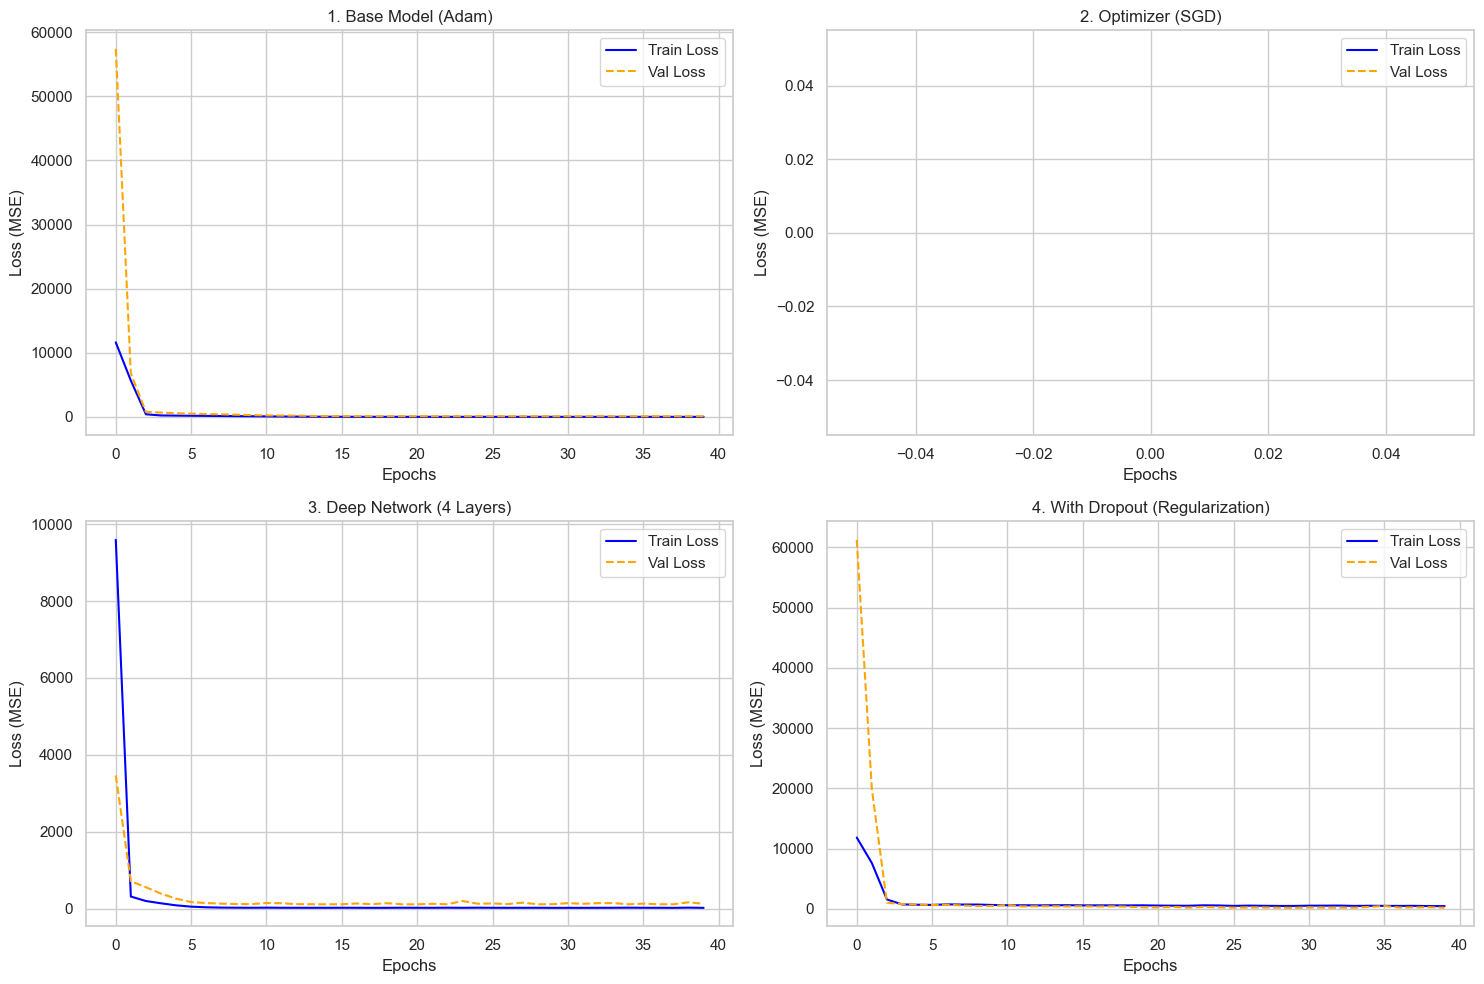

In [18]:
# ==========================================
# 🧪 تسک B: آزمایش و مقایسه مدل‌ها (Experiments)
# ==========================================
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers

# تابع سازنده مدل (برای راحتی ساخت مدل‌های مختلف)
def build_model(optimizer='adam', deep=False, dropout=False):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    # لایه اول
    model.add(layers.Dense(64, activation='relu'))
    if dropout: model.add(layers.Dropout(0.3)) # ۳۰٪ نورون‌ها را خاموش کن
    
    # لایه دوم
    model.add(layers.Dense(32, activation='relu'))
    if dropout: model.add(layers.Dropout(0.3))
    
    # اگر مدل عمیق بخواهیم، ۲ لایه اضافه می‌کنیم
    if deep:
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
    
    # لایه خروجی
    model.add(layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# لیست آزمایش‌ها
experiments = {
    "1. Base Model (Adam)": build_model(optimizer='adam'),
    "2. Optimizer (SGD)": build_model(optimizer=optimizers.SGD(learning_rate=0.01)),
    "3. Deep Network (4 Layers)": build_model(optimizer='adam', deep=True),
    "4. With Dropout (Regularization)": build_model(optimizer='adam', dropout=True)
}

# اجرای آزمایش‌ها و ذخیره نتایج
history_dict = {}

print("🚀 شروع آزمایش‌ها...")
plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(experiments.items()):
    print(f"⏳ Training {name}...")
    history = model.fit(
        X_train, y_train_r,
        validation_data=(X_test, y_test_r),
        epochs=40,          # ۴۰ دور آموزش
        batch_size=32,
        verbose=0
    )
    history_dict[name] = history
    
    # رسم نمودار همزمان
    plt.subplot(2, 2, i+1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange', linestyle='--')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

print("✅ تمام آزمایش‌ها انجام شد!")
plt.tight_layout()
plt.show()

### C. Discussion Questions

**1. Why are neural networks so powerful?**
Neural networks are powerful primarily due to two reasons:
* **Non-linearity:** Unlike classical linear models, neural networks use non-linear activation functions (like ReLU or Tanh). This allows them to model highly complex and intricate relationships between inputs and outputs.
* **Automatic Feature Learning:** In traditional ML, we often need to manually engineer features. Neural networks, however, learn the optimal features (representations) directly from the raw data during the training process.

**2. Why does training become more difficult as we go deeper?**
As we increase the depth of the network, training challenges arise:
* **Vanishing/Exploding Gradients:** During backpropagation, gradients are multiplied chain-wise. In deep networks, these gradients can shrink to zero (vanish) or grow infinitely (explode), causing the weights in earlier layers to stop updating or become unstable.
* **Overfitting:** Deeper networks have a larger number of parameters (higher capacity), making them more prone to memorizing the noise in the training data rather than generalizing.
* **Optimization Landscape:** The loss surface becomes more non-convex with more saddle points, making it harder for optimizers to find the global minimum.

**3. (Optional) Benefits of Depth vs. Width**
Although the Universal Approximation Theorem states that a wide enough single-layer network can approximate any function, **Depth** provides efficiency and hierarchy:
* **Hierarchical Learning:** Deep networks learn features in a hierarchy (e.g., edges -> shapes -> objects). This compositional structure matches the nature of real-world data (images, text).
* **Parameter Efficiency:** To represent a complex function, a shallow network might need exponentially more neurons (width) than a deep network. Depth allows the model to represent the same function with far fewer parameters.

part 2

⬇️ در حال دانلود دیتاست Fashion MNIST...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 69s 3us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 20s 4us/step
✅ دانلود تمام شد!
تعداد تصاویر آموزش: (60000, 28, 28)
تعداد تصاویر تست: (10000, 28, 28)


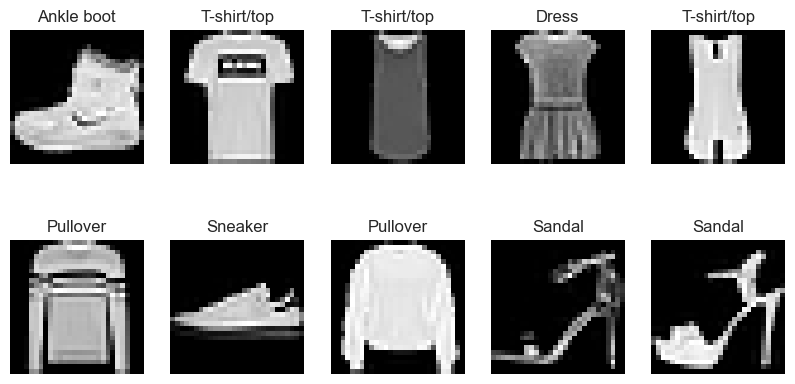

✅ دیتا آماده تزریق به شبکه CNN شد.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# --- 1. دانلود خودکار دیتاست Fashion MNIST ---
print("⬇️ در حال دانلود دیتاست Fashion MNIST...")
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# نام کلاس‌ها (چون y فقط عدد 0 تا 9 است، ما اسم‌گذاری می‌کنیم)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"✅ دانلود تمام شد!")
print(f"تعداد تصاویر آموزش: {X_train.shape}")
print(f"تعداد تصاویر تست: {X_test.shape}")

# --- 2. نمایش چند تصویر تصادفی ---
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap='gray') # نمایش تصویر
    plt.title(class_names[y_train[i]])  # نمایش اسم کلاس
    plt.axis('off') # حذف محورها
plt.show()

# --- 3. آماده‌سازی دیتا برای شبکه عصبی (خیلی مهم) ---
# تغییر ابعاد: CNN نیاز به بُعد کانال رنگ دارد (28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# تبدیل برچسب‌ها (y) به فرمت One-Hot (مثلاً 2 می‌شود [0,0,1,0,...])
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("✅ دیتا آماده تزریق به شبکه CNN شد.")

c:\Users\Hesam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)


🚀 شروع آموزش مدل CNN...
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8164 - loss: 0.5156 - val_accuracy: 0.8639 - val_loss: 0.3811
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8792 - loss: 0.3341 - val_accuracy: 0.8859 - val_loss: 0.3204
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8974 - loss: 0.2870 - val_accuracy: 0.8931 - val_loss: 0.2938
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9063 - loss: 0.2582 - val_accuracy: 0.8876 - val_loss: 0.2963
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9146 - loss: 0.2329 - val_accuracy: 0.9003 - val_loss: 0.2673
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9208 - loss: 0.2159 - val_accuracy: 0.9061 - val_loss: 0.2590
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9274 - loss: 0.1967 - val_accuracy: 0.9066 - val_loss: 0.2553
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9324 - loss: 

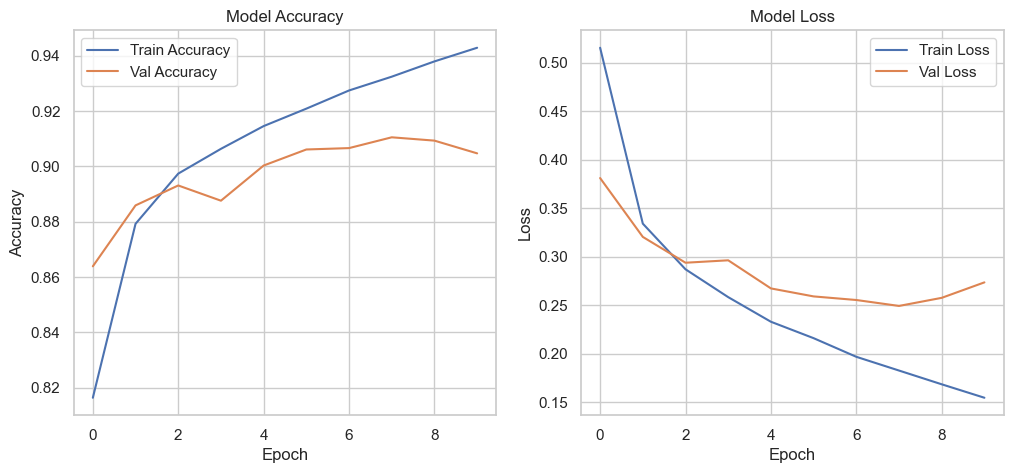

In [20]:
from tensorflow.keras import layers, models

# ==========================================
# 🏗️ ساخت مدل CNN (چشم مصنوعی)
# ==========================================
model_cnn = models.Sequential([
    # لایه ۱: استخراج ویژگی‌های اولیه (لبه‌ها و خطوط)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)), # کاهش ابعاد (زوم اوت)

    # لایه ۲: استخراج ویژگی‌های پیچیده‌تر (شکل‌ها)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # لایه ۳: تبدیل تصویر دو‌بعدی به لیست یک‌بعدی
    layers.Flatten(),
    
    # لایه ۴: تصمیم‌گیری نهایی (MLP معمولی)
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # ۱۰ کلاس خروجی (لباس‌ها)
])

# نمایش خلاصه معماری شبکه (خیلی برای گزارش مفید است)
model_cnn.summary()

# ==========================================
# 🚀 آموزش مدل
# ==========================================
print("\n🚀 شروع آموزش مدل CNN...")
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=10,             # ۱۰ دور آموزش
    batch_size=64,         # دسته‌های ۶۴ تایی
    validation_data=(X_test, y_test),
    verbose=1              # نمایش نوار پیشرفت
)

print("✅ آموزش تمام شد!")

# ==========================================
# 📊 رسم نمودار دقت و خطا
# ==========================================
plt.figure(figsize=(12, 5))

# نمودار دقت (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# نمودار خطا (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

⏳ Training 1. Base Model (3x3, MaxPool)...
⏳ Training 2. Large Kernel (5x5)...
⏳ Training 3. Average Pooling...


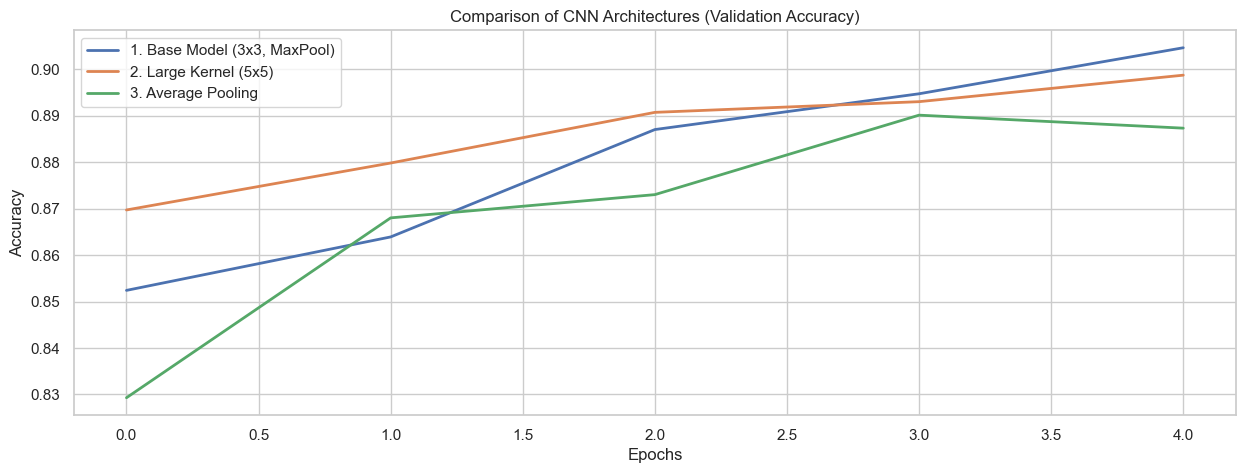

In [21]:
# ==========================================
# 🧪 تسک B: آزمایش پارامترهای CNN
# ==========================================

def build_cnn(filters=32, kernel_size=(3,3), pool_type='max'):
    model = models.Sequential()
    
    # لایه ۱
    model.add(layers.Conv2D(filters, kernel_size, activation='relu', input_shape=(28, 28, 1)))
    
    if pool_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2))) # میانگین‌گیری به جای ماکزیمم
    
    # لایه ۲
    model.add(layers.Conv2D(filters*2, kernel_size, activation='relu'))
    
    if pool_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# تعریف آزمایش‌ها
experiments_cnn = {
    "1. Base Model (3x3, MaxPool)": build_cnn(filters=32, kernel_size=(3,3), pool_type='max'),
    "2. Large Kernel (5x5)": build_cnn(filters=32, kernel_size=(5,5), pool_type='max'),
    "3. Average Pooling": build_cnn(filters=32, kernel_size=(3,3), pool_type='avg')
}

# اجرا و رسم نمودار
plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(experiments_cnn.items()):
    print(f"⏳ Training {name}...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    plt.plot(history.history['val_accuracy'], label=name, linewidth=2)

plt.title('Comparison of CNN Architectures (Validation Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


🚀 Training with Data Augmentation...
Epoch 1/10


c:\Users\Hesam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6568 - loss: 0.9440 - val_accuracy: 0.7630 - val_loss: 0.6280
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7343 - loss: 0.7131 - val_accuracy: 0.7871 - val_loss: 0.5787
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7634 - loss: 0.6430 - val_accuracy: 0.8073 - val_loss: 0.5186
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7796 - loss: 0.6010 - val_accuracy: 0.8169 - val_loss: 0.5140
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7917 - loss: 0.5691 - val_accuracy: 0.8177 - val_loss: 0.5009
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8004 - loss: 0.5477 - val_accuracy: 0.8294 - val_loss: 0.4735
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8126 - loss: 0.5203 - val_accuracy: 0.8241 - val_loss: 0.5046
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8160 - loss: 0.5054 - val_accuracy: 0.8425 

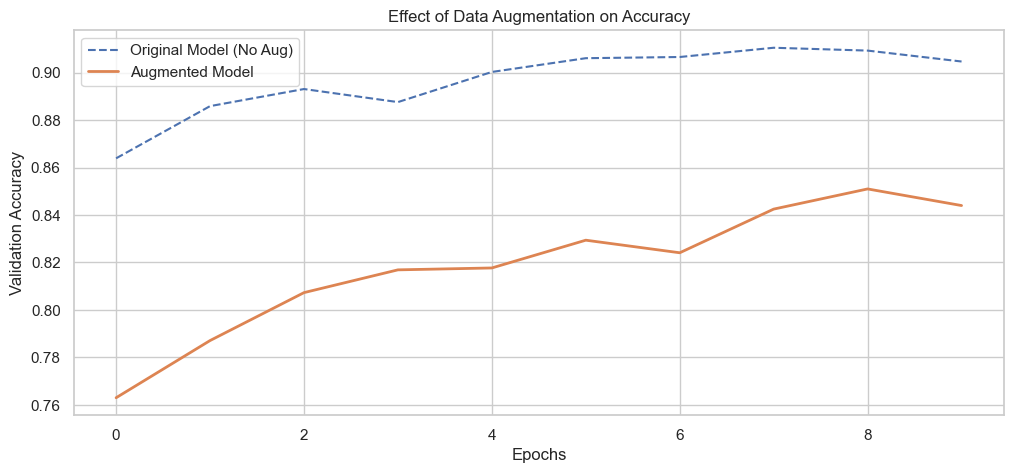

In [22]:
# ==========================================
# 🔄 تسک C: Data Augmentation (افزایش داده)
# ==========================================

# 1. تعریف لایه‌های تغییر دهنده عکس
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(28, 28, 1)), # عکس را آینه‌ای کن
    layers.RandomRotation(0.1),   # ۱۰٪ بچرخان
    layers.RandomZoom(0.1),       # ۱۰٪ زوم کن
])

# 2. ساخت مدل جدید با این لایه‌ها
model_aug = models.Sequential([
    data_augmentation,  # اول عکس را تغییر بده
    
    # بعد بده به لایه‌های کانولوشن (همان مدل قبلی)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # یک تکنیک دیگر برای جلوگیری از حفظ کردن
    layers.Dense(10, activation='softmax')
])

# 3. کامپایل و آموزش
print("\n🚀 Training with Data Augmentation...")
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_aug = model_aug.fit(
    X_train, y_train,
    epochs=10, 
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# 4. مقایسه نتایج
plt.figure(figsize=(12, 5))
plt.plot(history_cnn.history['val_accuracy'], label='Original Model (No Aug)', linestyle='--')
plt.plot(history_aug.history['val_accuracy'], label='Augmented Model', linewidth=2)
plt.title('Effect of Data Augmentation on Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 79s 1us/step

🚀 Training VGG16 based model...


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,592 (56.64 MB)

 Trainable params: 133,904 (523.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 227s 241ms/step - accuracy: 0.6111 - loss: 1.1636 - val_accuracy: 0.7729 - val_loss: 0.6785
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 221s 236ms/step - accuracy: 0.7641 - loss: 0.6751 - val_accuracy: 0.7977 - val_loss: 0.5683
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 221s 236ms/step - accuracy: 0.7925 - loss: 0.5864 - val_accuracy: 0.8164 - val_loss: 0.5207
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 225s 240ms/step - accuracy: 0.8079 - loss: 0.5393 - val_accuracy: 0.8259 - val_loss: 0.4938
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 223s 238ms/step - accuracy: 0.8171 - loss: 0.5117 - val_accuracy: 0.8323 - val_loss: 0.4735


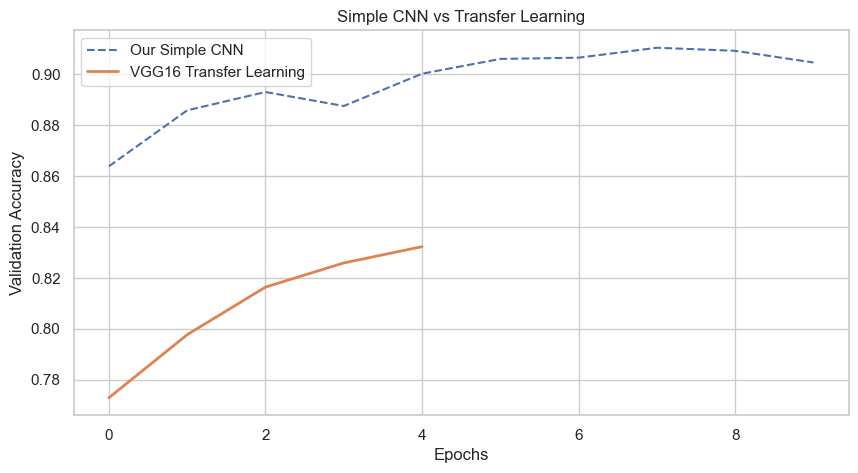

In [23]:
# ==========================================
# 🧠 تسک D: Transfer Learning (با مدل VGG16)
# ==========================================
from tensorflow.keras.applications import VGG16

# 1. دانلود "بدنه" مدل VGG16 (بدون لایه‌های آخر)
# include_top=False: یعنی قسمت تصمیم‌گیری نهایی را حذف کن (چون مال ما فرق داره)
# weights='imagenet': یعنی از دانش قبلی استفاده کن
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 2. فریز کردن (Freeze) لایه‌ها
# این کار باعث می‌شود وزن‌های مدل اصلی تغییر نکنند و فقط لایه‌های جدید ما آموزش ببینند.
base_model.trainable = False 

# 3. ساخت مدل جدید
model_tl = models.Sequential([
    # --- لایه‌های پیش‌پردازش (تطبیق ورودی) ---
    layers.Input(shape=(28, 28, 1)),          # ورودی اصلی ما (سیاه و سفید کوچک)
    layers.Resizing(32, 32),                  # بزرگ کردن عکس به ۳۲x۳۲ (حداقلِ VGG)
    layers.Conv2D(3, (1, 1), padding='same'), # تبدیل ۱ کانال به ۳ کانال (شبیه‌سازی رنگی)
    
    # --- بدنه اصلی (VGG16) ---
    base_model,                               # مغز اجاره‌ای!
    
    # --- لایه‌های تصمیم‌گیری جدید ---
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    # ۱۰ کلاس لباس
])

# 4. کامپایل و آموزش
print("\n🚀 Training VGG16 based model...")
# نکته: برای فاین‌تیونینگ معمولاً Learning Rate را کمتر می‌گیرند
model_tl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()

history_tl = model_tl.fit(
    X_train, y_train,
    epochs=5,           # ۵ دور کافیست (چون مدل قبلاً چیزهای زیادی بلد است)
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# 5. مقایسه با مدل خودمان
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['val_accuracy'], label='Our Simple CNN', linestyle='--')
plt.plot(history_tl.history['val_accuracy'], label='VGG16 Transfer Learning', linewidth=2)
plt.title('Simple CNN vs Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

### E. Discussion Question: CNN vs MLP

**1. Why are CNNs more parameter-efficient?**
CNNs are efficient because of:
* **Parameter Sharing:** In a CNN, the same filter (kernel) is used across the entire image. In an MLP, every input pixel has a separate weight connection to every neuron. This drastically reduces the number of parameters in CNNs.
* **Local Connectivity:** CNNs focus on local patterns (neighbors pixels), whereas MLPs treat pixels far apart as equally related.

**2. When could an MLP match CNN?**
Theoretically, if we have an infinite amount of data and infinite computational power, an MLP *could* learn to behave like a CNN (by learning weight matrices that look like convolution filters). However, in practice, this is unrealistic because it would require massive memory and training time, and would likely overfit instantly due to the huge number of parameters.

✅ دیتاست تسلا بارگذاری شد.
X_train shape: (3048, 60, 1)

🚀 Training SIMPLE Model...


c:\Users\Hesam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🚀 Training LSTM Model...

🚀 Training GRU Model...


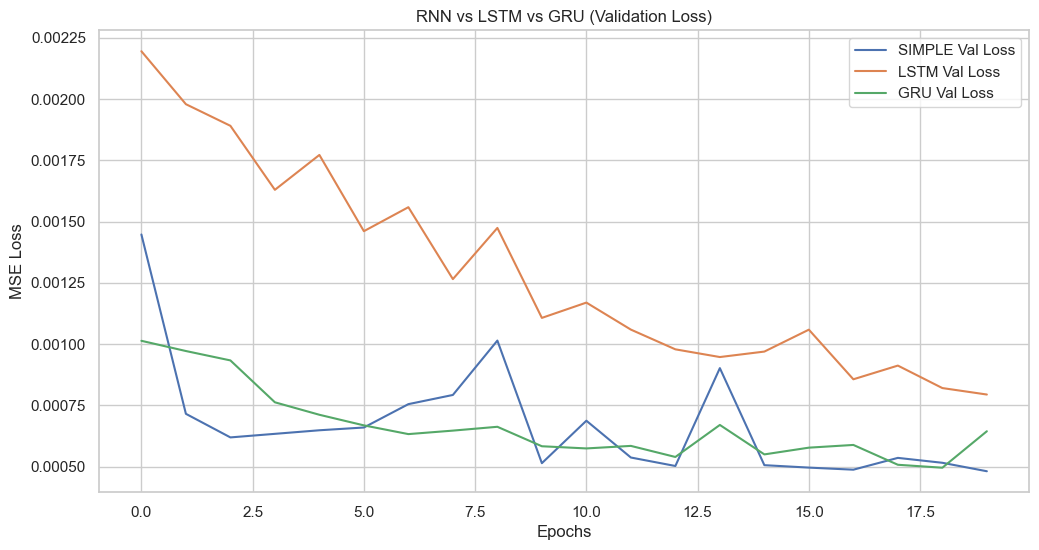

In [24]:
# ==========================================
# 📈 بخش سوم: شبکه‌های بازگشتی (RNNs)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models

# --- 1. آماده‌سازی دیتا (Data Loading) ---
try:
    df = pd.read_csv("C:/Users/Hesam/Desktop/tesla_stock_history.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    data = df['Close'].values.reshape(-1, 1) # فقط روی قیمت Close تمرکز می‌کنیم
    print("✅ دیتاست تسلا بارگذاری شد.")
except:
    print("⚠️ فایل پیدا نشد! ساخت دیتای ساختگی...")
    # ساخت دیتای سینوسی (شبیه نوسان بورس)
    t = np.linspace(0, 100, 2000)
    data = (np.sin(t) + np.sin(0.5*t) + np.random.normal(0, 0.1, 2000)).reshape(-1, 1)

# --- 2. پیش‌پردازش مخصوص RNN (خیلی مهم) ---
# RNNها حساسند، داده‌ها باید بین ۰ و ۱ باشند
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# تابعی برای تبدیل دیتا به توالی (Sequence)
# یعنی: ۶۰ روز گذشته را بگیر (X) -> روز ۶۱ام را پیش‌بینی کن (y)
def create_sequences(dataset, seq_length=60):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # طول حافظه (۶۰ روز)
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# تقسیم به آموزش و تست (بدون Shuffle چون زمان مهم است)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}") # (Samples, 60, 1)

# --- 3. ساخت توابع مدل‌ساز ---
def build_rnn_model(model_type='simple'):
    model = models.Sequential()
    input_shape = (X_train.shape[1], 1)
    
    if model_type == 'simple':
        model.add(layers.SimpleRNN(50, input_shape=input_shape))
    elif model_type == 'lstm':
        model.add(layers.LSTM(50, input_shape=input_shape))
    elif model_type == 'gru':
        model.add(layers.GRU(50, input_shape=input_shape))
        
    model.add(layers.Dense(1)) # لایه خروجی (پیش‌بینی قیمت)
    model.compile(optimizer='adam', loss='mse')
    return model

# --- 4. آموزش و مقایسه ۳ مدل ---
model_types = ['simple', 'lstm', 'gru']
histories = {}

plt.figure(figsize=(12, 6))

for m_type in model_types:
    print(f"\n🚀 Training {m_type.upper()} Model...")
    model = build_rnn_model(m_type)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                        validation_data=(X_test, y_test), verbose=0)
    histories[m_type] = history
    
    # رسم نمودار
    plt.plot(history.history['val_loss'], label=f'{m_type.upper()} Val Loss')

plt.title('RNN vs LSTM vs GRU (Validation Loss)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


🚀 Training Bidirectional LSTM...


c:\Users\Hesam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


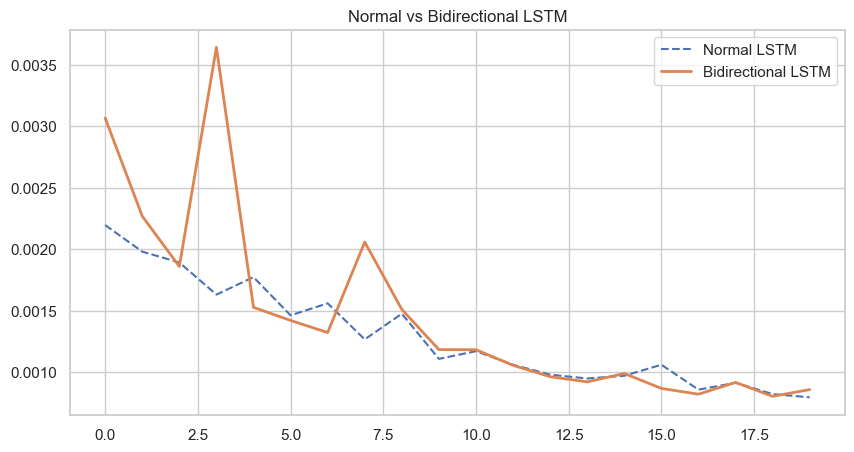

In [25]:
# ==========================================
# 🧪 تسک B: آزمایش Bidirectional LSTM
# ==========================================
print("\n🚀 Training Bidirectional LSTM...")

model_bi = models.Sequential([
    # Bidirectional به مدل اجازه می‌دهد دیتا را از دو جهت ببیند
    layers.Bidirectional(layers.LSTM(50), input_shape=(SEQ_LENGTH, 1)),
    layers.Dense(1)
])

model_bi.compile(optimizer='adam', loss='mse')
history_bi = model_bi.fit(X_train, y_train, epochs=20, batch_size=32, 
                          validation_data=(X_test, y_test), verbose=0)

# مقایسه با LSTM معمولی
plt.figure(figsize=(10, 5))
plt.plot(histories['lstm'].history['val_loss'], label='Normal LSTM', linestyle='--')
plt.plot(history_bi.history['val_loss'], label='Bidirectional LSTM', linewidth=2)
plt.title('Normal vs Bidirectional LSTM')
plt.legend()
plt.show()

### C. Discussion Question: RNNs

**1. Why are LSTMs and GRUs better than Vanilla RNNs?**
Vanilla RNNs suffer from the **Vanishing Gradient Problem**. During backpropagation through time, gradients can become extremely small, causing the network to stop learning form early time steps (short-term memory only). LSTMs and GRUs solve this by maintaining a separate cell state that can keep information flow constant over long sequences.

**2. Role of Gates:**
* **Forget Gate (LSTM):** Decides what information to discard from the cell state.
* **Input Gate (LSTM):** Decides what new information to store.
* **Update Gate (GRU):** A combination of forget and input gates.
These gates act like valves, allowing the network to selectively remember or forget information, thus handling long-term dependencies effectively.


🚀 Training Transformer Model...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - loss: 0.0176 - val_loss: 0.0148
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - loss: 0.0035 - val_loss: 0.0137
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - loss: 0.0027 - val_loss: 0.0120
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - loss: 0.0028 - val_loss: 0.0120
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 279ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - loss: 0.0024 - val_loss: 0.0118
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - loss: 0.0023 - val_loss: 0.0112
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - loss: 0.0023 - val_loss: 0.0113
Epoch 12

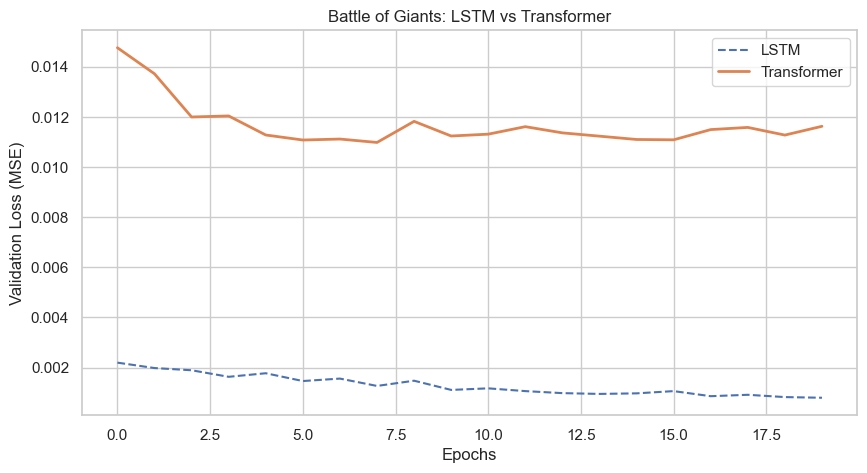

In [26]:
# ==========================================
# 🤖 بخش چهارم: مدل Transformer (Time-Series)
# ==========================================
from tensorflow.keras import layers, models, Input

# 1. تعریف بلوک ترنسفورمر (این قلب تپنده مدل است)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # بخش توجه (Attention): کجای نمودار مهم است؟
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # اتصال کوتاه (Residual Connection)

    # بخش شبکه عصبی معمولی (Feed Forward)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 2. ساخت مدل اصلی
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # تکرار بلوک‌های ترنسفورمر
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # لایه‌های نهایی برای تصمیم‌گیری
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(1)(x) # خروجی نهایی (قیمت)
    return models.Model(inputs, outputs)

# 3. تنظیم پارامترها و آموزش
input_shape = (X_train.shape[1], 1) # (60, 1)

print("\n🚀 Training Transformer Model...")
model_trans = build_transformer_model(
    input_shape,
    head_size=256,      # سایز بردار توجه
    num_heads=4,        # تعداد کله‌های توجه (Multi-Head)
    ff_dim=4,           # سایز لایه مخفی
    num_transformer_blocks=4, # تعداد لایه‌های ترنسفورمر
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_trans.compile(optimizer="adam", loss="mse")

history_trans = model_trans.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,          # ترنسفورمرها معمولاً به epochs بیشتری نیاز دارند
    batch_size=64,
    verbose=1
)

# 4. مقایسه نهایی: Transformer vs LSTM
plt.figure(figsize=(10, 5))
# فرض می‌کنیم history_lstm از مرحله قبل در حافظه هست (اگر نیست خط بعد را کامنت کن)
if 'lstm' in histories:
    plt.plot(histories['lstm'].history['val_loss'], label='LSTM', linestyle='--')

plt.plot(history_trans.history['val_loss'], label='Transformer', linewidth=2)
plt.title('Battle of Giants: LSTM vs Transformer')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.show()

### 4-C. Discussion Questions: Transformers

**1. Main Advantages and Disadvantages:**
* **Pros:** Parallelization (unlike RNNs, they process the whole sequence at once, making training faster on GPUs), handling long-range dependencies effectively.
* **Cons:** High computational cost (quadratic complexity with respect to sequence length), requires large amounts of data to generalize well.

**2. Why do they scale well?**
Transformers lack recurrence (loops), which allows for massive parallelization across thousands of GPU cores. This makes them ideal for training on internet-scale datasets (like GPT models).

**3. What is Self-Attention?**
Self-attention is a mechanism that allows the model to weigh the importance of different words (or time steps) in a sequence relative to each other. It solves the problem of "context" by dynamically focusing on relevant parts of the input regardless of their distance.

**4. Why is Multi-Head Attention helpful?**
It allows the model to focus on different types of relationships simultaneously. For example, one "head" might focus on short-term price trends, while another focuses on long-term seasonality.

**5. Positional Encoding:**
Since Transformers process all inputs simultaneously (no inherent order), Positional Encoding adds unique vectors to the input embeddings to give the model information about the order/position of data points in the sequence.

# Bonus: Industry Review & Future Predictions

## 1. What is used in Industry NOW?
Contrary to the AI hype, classical models still dominate tabular data tasks (Finance, Retail, Operations). According to recent Kaggle surveys and industry reports:
* **Gradient Boosted Trees (XGBoost, LightGBM):** The gold standard for structured/tabular data due to speed and performance.
* **Linear/Logistic Regression:** Widely used in banking and healthcare where **interpretability** is more important than raw accuracy.
* **Deep Learning (CNNs, Transformers):** Dominates exclusively in unstructured data domains (Computer Vision, NLP, Audio).

## 2. Future Prediction (Next 5-10 Years)
* **Commoditization of LLMs:** Large Language Models will become foundational infrastructure (like electricity), integrated into almost every software via APIs rather than being built from scratch.
* **Rise of AutoML:** Manual model selection for standard tasks will disappear. Automated systems will handle model training, shifting the Data Scientist's role towards "Data Engineering" and "Business Logic".
* **Small is the new Big:** There will be a shift from massive generic models to smaller, highly specialized, and efficient models (SLMs) that can run on edge devices (phones, IoT) to reduce cloud costs and preserve privacy.